In [1]:
#Imports

import math
import numpy as np 
from scipy import stats
from scipy.special import logit as lgTransform
from scipy.interpolate import UnivariateSpline
import pandas as pd
import statsmodels.api as sm 
import matplotlib.pylab as plt 
from sklearn.linear_model import LogisticRegression
import statsmodels.formula.api as smf
from statsmodels.formula.api import logit
import seaborn as sns
%matplotlib inline

In [2]:
#Load data

df = pd.read_csv('finalModelcsvs/fake_transcript_variants_mis_v5_chrom1_new.csv')
#print(df.head())
#print(df.tail())
colDf = df.columns
print(colDf)
print("Number of columns: ", len(colDf))
print("Original df length: ", len(df))
#print(df.head())
#print(df.tail())

/Users/Admin/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Index(['chrom', 'pos', 'gene', 'ref', 'alt', 'freq', 'PPH', 'AA_change', 'mu',
       'qual', 'context', 'mean', 'median', 'over_20', 'over_50', 'over_100',
       'filter', 'an', 'ac', 'allele_type', 'has_star', 'lcr', 'rf_label',
       'interp_dist', 'GIAB'],
      dtype='object')
Number of columns:  25
Original df length:  5247179


In [3]:
#Filtering out bad variants
#freq > 0 &  (ac==0 | filter!="PASS" | has_star | lcr | rf_label=="FP" | allele_type != "snv")

# dfGoodVariants = df[((df['freq'] > 0) & (df['ac'] == 0 | df['filter'] != 'PASS'
#                                         | df['has_star'] == True | df['lcr'] == True 
#                                         | df['rf_label'] == "FP" | df['allele_type'] != "snv"))]

dfBadVariants = df[df['freq'] > 0]
dfBadVariantsAlleleCount = dfBadVariants[dfBadVariants['ac'] == 0]
dfBadVariantsFilterQuality = dfBadVariants[dfBadVariants['filter'] != 'PASS']
dfBadVariantsHasStar = dfBadVariants[dfBadVariants['has_star'] == True]
dfBadVariantsLCR = dfBadVariants[dfBadVariants['lcr'] == True]
dfBadVariantsRFLabel = dfBadVariants[dfBadVariants['rf_label'] == 'FP']
dfBadVariantsAlleleType = dfBadVariants[dfBadVariants['allele_type'] != 'snv']

dfFinalBadVariants = pd.concat([dfBadVariantsAlleleCount, dfBadVariantsFilterQuality, dfBadVariantsHasStar, dfBadVariantsLCR, dfBadVariantsRFLabel, dfBadVariantsAlleleType], sort=False).sort_index()

print("AC: ", len(dfBadVariantsAlleleCount))
print("Filter: ", len(dfBadVariantsFilterQuality))
print("Has Star: ", len(dfBadVariantsHasStar))
print("LCR: ", len(dfBadVariantsLCR))
print("RF Label", len(dfBadVariantsRFLabel))
print("Allele Type", len(dfBadVariantsAlleleType))

print("Final bad variant set length: ", len(dfFinalBadVariants))
#print(dfFinalBadVariants.head())
#print(dfFinalBadVariants.tail(20))

#print(dfBadVariants['allele_type'].head())

#print("Filter out bad variants length: ", len(dfBadVariants))
#print(dfBadVariants.head())

AC:  21
Filter:  11750
Has Star:  23334
LCR:  408
RF Label 10678
Allele Type 4
Final bad variant set length:  46195


In [4]:
badIndexes = dfFinalBadVariants.index
badSites = dfFinalBadVariants.pos
print(dfFinalBadVariants.index)

df.drop(badIndexes, inplace = True)
dfGoodVariants = df
print(len(dfGoodVariants))
#print(dfGoodVariants.head())
#print(dfGoodVariants.tail())

Int64Index([     64,     118,     118,     444,     506,     506,     527,
                549,     553,     623,
            ...
            5245687, 5246112, 5246198, 5246240, 5246242, 5246249, 5246785,
            5247009, 5247013, 5247015],
           dtype='int64', length=46195)
5207813


In [5]:
#Coverage and quality filtering
# qual=="high", over_20>0.8,freq==0 & interp_dist==0 & allele_type != "snv", ENSG00000242265

print("Good variants length: ", len(dfGoodVariants))

#Keep sites with high quality
dfQuality = dfGoodVariants[dfGoodVariants['qual'] == 'high']
print("Quality filtering: ", len(dfQuality))

#Keep sites with over_20 coverage > 0.8
dfFilterQuality80 = dfQuality[dfQuality['over_20'] > 0.8]
print(len(dfFilterQuality80))

#Change GIAB from T/F to binary variable
dfFilterQuality80["GIAB"] = dfFilterQuality80["GIAB"].astype(int)

#Filter freq == 0, #Filter interp_distance == 0, #Filter sites allele_type != "snv"
maskCoverage = (dfFilterQuality80['freq'] == 0) & (dfFilterQuality80['interp_dist'] == 0) & (dfFilterQuality80['allele_type'] != 'snv')

dfFilterQuality80FreqInterpAlleleType = dfFilterQuality80[maskCoverage]

# dfFilterQuality80 = dfFilterQuality80[dfFilterQuality80['freq'] != 0]
# dfFilterQuality80 = dfFilterQuality80[dfFilterQuality80['interp_dist'] != 0]
# dfFilterQuality80 = dfFilterQuality80[dfFilterQuality80['allele_type'] == 'snv']

freqInterpAlleleTypeIndexes = dfFilterQuality80FreqInterpAlleleType.index
print(freqInterpAlleleTypeIndexes)
dfFilterQuality80.drop(freqInterpAlleleTypeIndexes, inplace = True)
print(len(dfFilterQuality80))

#Filter sites in the gene ENSG00000242265
dfFilterQuality80 = dfFilterQuality80[dfFilterQuality80['gene'] != 'ENSG00000242265']
print(len(dfFilterQuality80))

#print(dfQuality.head())

print("After filtering for freq == 0 and interp_dist == 0: ", len(dfFilterQuality80))
#print(dfFilterQuality80.head())
#print(dfFilterQuality80.tail())

print(len(dfFilterQuality80FreqInterpAlleleType))
#print(dfFilterQuality80FreqInterpAlleleType.head())

Good variants length:  5207813
Quality filtering:  4856519
3908902


<ipython-input-5-f0edf46b95fc>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfFilterQuality80["GIAB"] = dfFilterQuality80["GIAB"].astype(int)


Int64Index([   4123,    4124,    4362,    4363,    4561,    4562,    4622,
               4712,    5000,    5001,
            ...
            5245407, 5246082, 5246083, 5246170, 5246171, 5246462, 5246463,
            5246468, 5247002, 5247059],
           dtype='int64', length=31108)


/Users/Admin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


3877794
3877794
After filtering for freq == 0 and interp_dist == 0:  3877794
31108


In [6]:
dfFilterQuality80.insert(25, 'CpG_context', [1 for x in range(len(dfFilterQuality80))])
#print(dfFilterQuality80.head())

In [7]:
#CpG Transitions

context = dfFilterQuality80.context.tolist()
ref = dfFilterQuality80.ref.tolist()
alt = dfFilterQuality80.alt.tolist()
CpGArray = np.zeros(len(context))
CpGArrayIndex = 0

for i in range(len(context)):
    contextString = context[i]
    for j in range(len(contextString)-1):
        if (contextString[j] == 'C' and contextString[j+1] == 'G'):
            if ((ref[i] == 'G' and alt[i] == 'A') or (ref[i] == 'C' and alt[i] == 'T')):
                CpGArray[CpGArrayIndex] = 1
    CpGArrayIndex = CpGArrayIndex + 1

# for k in range(100): 
#     print(CpGArray[k])
    
# print(dfFilterQuality80.context.head(50))
# print(len(CpGArray))

dfFilterQuality80['CpG_context'] = CpGArray.tolist()
#dfChuckles = dfFilterQuality80[['context', 'CpG_context']]
#print(dfChuckles.head(50))
print(dfFilterQuality80.head())

      chrom     pos             gene ref alt      freq  \
1493      1  925945  ENSG00000187634   T   A  0.000000   
1494      1  925945  ENSG00000187634   T   C  0.000000   
1495      1  925945  ENSG00000187634   T   G  0.000000   
1496      1  925946  ENSG00000187634   C   G  0.000012   
1497      1  925946  ENSG00000187634   C   T  0.000000   

                           PPH AA_change     mu  qual  ... filter        an  \
1493  possibly_damaging(0.883)   Ser2Thr  0.030  high  ...   PASS  249448.0   
1494             benign(0.086)   Ser2Pro  0.051  high  ...   PASS  249448.0   
1495   possibly_damaging(0.77)   Ser2Ala  0.020  high  ...   PASS  249448.0   
1496  probably_damaging(0.987)   Ser2Cys  0.073  high  ...   PASS  249448.0   
1497  probably_damaging(0.972)   Ser2Phe  0.198  high  ...   PASS  249448.0   

       ac  allele_type  has_star    lcr rf_label  interp_dist  GIAB  \
1493  3.0          snv     False  False      NaN            1     1   
1494  3.0          snv     False  

In [8]:
# dfCpG = dfFilterQuality80.loc[dfFilterQuality80['CpG_context'] == 1]
# ref = dfCpG.ref.tolist()
# alt = dfCpG.alt.tolist()
# CpGArrayTransitions = np.zeros(len(dfCpG))
# CpGTransitionsArrayIndex = 0

# for i in range(len(dfCpG)): 
#     if ((ref[i] == 'G' and alt[i] == 'A') or (ref[i] == 'C' and alt[i] == 'T')):
#         CpGArrayTransitions[CpGTransitionsArrayIndex] = 1
#     CpGTransitionsArrayIndex = CpGTransitionsArrayIndex + 1

# for k in range(100):
#     print(CpGArrayTransitions[k])

# #print(CpGArrayTransitions)
# print(len(dfCpG))
# print(dfCpG.head(50))

In [9]:
#Dependent var freq > 0 logistic_freq

dfFilterQuality80.insert(26, 'logistic_freq', [1 for x in range(len(dfFilterQuality80))])
dfFilterQuality80['logistic_freq'] = np.where((dfFilterQuality80.freq == 0), 0, dfFilterQuality80.logistic_freq)
print(dfFilterQuality80.head())

      chrom     pos             gene ref alt      freq  \
1493      1  925945  ENSG00000187634   T   A  0.000000   
1494      1  925945  ENSG00000187634   T   C  0.000000   
1495      1  925945  ENSG00000187634   T   G  0.000000   
1496      1  925946  ENSG00000187634   C   G  0.000012   
1497      1  925946  ENSG00000187634   C   T  0.000000   

                           PPH AA_change     mu  qual  ...        an   ac  \
1493  possibly_damaging(0.883)   Ser2Thr  0.030  high  ...  249448.0  3.0   
1494             benign(0.086)   Ser2Pro  0.051  high  ...  249448.0  3.0   
1495   possibly_damaging(0.77)   Ser2Ala  0.020  high  ...  249448.0  3.0   
1496  probably_damaging(0.987)   Ser2Cys  0.073  high  ...  249448.0  3.0   
1497  probably_damaging(0.972)   Ser2Phe  0.198  high  ...  249448.0  3.0   

      allele_type  has_star    lcr  rf_label interp_dist  GIAB  CpG_context  \
1493          snv     False  False       NaN           1     1          0.0   
1494          snv     False  F

In [10]:
#log transform mu
dfFilterQuality80['log_mu'] = np.log10(dfFilterQuality80['mu'])
print(dfFilterQuality80.head())

      chrom     pos             gene ref alt      freq  \
1493      1  925945  ENSG00000187634   T   A  0.000000   
1494      1  925945  ENSG00000187634   T   C  0.000000   
1495      1  925945  ENSG00000187634   T   G  0.000000   
1496      1  925946  ENSG00000187634   C   G  0.000012   
1497      1  925946  ENSG00000187634   C   T  0.000000   

                           PPH AA_change     mu  qual  ...   ac  allele_type  \
1493  possibly_damaging(0.883)   Ser2Thr  0.030  high  ...  3.0          snv   
1494             benign(0.086)   Ser2Pro  0.051  high  ...  3.0          snv   
1495   possibly_damaging(0.77)   Ser2Ala  0.020  high  ...  3.0          snv   
1496  probably_damaging(0.987)   Ser2Cys  0.073  high  ...  3.0          snv   
1497  probably_damaging(0.972)   Ser2Phe  0.198  high  ...  3.0          snv   

      has_star    lcr  rf_label  interp_dist GIAB  CpG_context  logistic_freq  \
1493     False  False       NaN            1    1          0.0              0   
1494    

In [11]:
#log transform mu^2
dfFilterQuality80['log_mu_squared'] = (np.log10(dfFilterQuality80['mu']))**2
print(dfFilterQuality80.head())

      chrom     pos             gene ref alt      freq  \
1493      1  925945  ENSG00000187634   T   A  0.000000   
1494      1  925945  ENSG00000187634   T   C  0.000000   
1495      1  925945  ENSG00000187634   T   G  0.000000   
1496      1  925946  ENSG00000187634   C   G  0.000012   
1497      1  925946  ENSG00000187634   C   T  0.000000   

                           PPH AA_change     mu  qual  ... allele_type  \
1493  possibly_damaging(0.883)   Ser2Thr  0.030  high  ...         snv   
1494             benign(0.086)   Ser2Pro  0.051  high  ...         snv   
1495   possibly_damaging(0.77)   Ser2Ala  0.020  high  ...         snv   
1496  probably_damaging(0.987)   Ser2Cys  0.073  high  ...         snv   
1497  probably_damaging(0.972)   Ser2Phe  0.198  high  ...         snv   

      has_star    lcr  rf_label  interp_dist  GIAB CpG_context  logistic_freq  \
1493     False  False       NaN            1     1         0.0              0   
1494     False  False       NaN            1

In [12]:
#GIAB CpG Interaction
dfFilterQuality80['GIAB_CpG_Interaction'] = dfFilterQuality80['GIAB'] * dfFilterQuality80['CpG_context']
print(dfFilterQuality80.head())

      chrom     pos             gene ref alt      freq  \
1493      1  925945  ENSG00000187634   T   A  0.000000   
1494      1  925945  ENSG00000187634   T   C  0.000000   
1495      1  925945  ENSG00000187634   T   G  0.000000   
1496      1  925946  ENSG00000187634   C   G  0.000012   
1497      1  925946  ENSG00000187634   C   T  0.000000   

                           PPH AA_change     mu  qual  ... has_star    lcr  \
1493  possibly_damaging(0.883)   Ser2Thr  0.030  high  ...    False  False   
1494             benign(0.086)   Ser2Pro  0.051  high  ...    False  False   
1495   possibly_damaging(0.77)   Ser2Ala  0.020  high  ...    False  False   
1496  probably_damaging(0.987)   Ser2Cys  0.073  high  ...    False  False   
1497  probably_damaging(0.972)   Ser2Phe  0.198  high  ...    False  False   

      rf_label  interp_dist  GIAB  CpG_context logistic_freq    log_mu  \
1493       NaN            1     1          0.0             0 -1.522879   
1494       NaN            1     1 

In [13]:
#Final model Loss of Function

#final_mod = smf.glm('logistic_freq ~ mu + log_mu + log_mu_squared + GIAB + CpG_context + GIAB_CpG_Interaction + median', data = dfFilterQuality80, family = sm.families.Binomial()).fit()
#print(final_mod.summary())

In [14]:
def calculateLogisticProbSynon(intercept, muMod, log_muMod, log_mu_squaredMod, GIABMod, CpG_contextMod, GIAB_CpG_InteractionMod, medianMod, mu, log_mu, log_mu_squared, GIAB, CpG_context, GIAB_CpG_Interaction, median):
        probability = 1 / (1 + math.exp(-1 * ((intercept + (mu * muMod) + (log_muMod * log_mu) + (log_mu_squared * log_mu_squaredMod) + (GIAB * GIABMod) + (CpG_contextMod * CpG_context) + (GIAB_CpG_InteractionMod * GIAB_CpG_Interaction) + (median * medianMod)))))
        return probability
        
interceptMod, muMod, log_muMod, log_mu_squaredMod, GIABMod, CpG_contextMod, GIAB_CpG_InteractionMod, medianMod = 0.1184, 0.8243, 1.9851, -0.1254, 0.0365, 0.0065, -0.2032, 0.0006 #Coefficients for synon final model

In [15]:
dfFilterQuality80['probability_final_mod'] = [1 for x in range(len(dfFilterQuality80))]
probFinalModArray = np.zeros(len(dfFilterQuality80))

muArray = dfFilterQuality80.mu.tolist()
log_muArray = dfFilterQuality80.log_mu.tolist()
log_mu_squaredArray = dfFilterQuality80.log_mu_squared.tolist()
GIABArray = dfFilterQuality80.GIAB.tolist()
CpG_contextArray = dfFilterQuality80.CpG_context.tolist()
GIAB_CpG_InteractionArray = dfFilterQuality80.GIAB_CpG_Interaction.tolist()
medianArray = dfFilterQuality80['median'].tolist()

for i in range(len(dfFilterQuality80)):
    mu = muArray[i]
    log_mu = log_muArray[i]
    log_mu_squared = log_mu_squaredArray[i]
    GIAB = GIABArray[i]
    CpG_context = CpG_contextArray[i]
    GIAB_CpG_Interaction = GIAB_CpG_InteractionArray[i]
    median = medianArray[i]
    
    newProb = calculateLogisticProbSynon(interceptMod, muMod, log_muMod, log_mu_squaredMod, GIABMod, CpG_contextMod, GIAB_CpG_InteractionMod, medianMod, mu, log_mu, log_mu_squared, GIAB, CpG_context, GIAB_CpG_Interaction, median)
    probFinalModArray[i] = newProb
    
dfFilterQuality80['probability_final_mod'] = probFinalModArray
print(dfFilterQuality80.head())

      chrom     pos             gene ref alt      freq  \
1493      1  925945  ENSG00000187634   T   A  0.000000   
1494      1  925945  ENSG00000187634   T   C  0.000000   
1495      1  925945  ENSG00000187634   T   G  0.000000   
1496      1  925946  ENSG00000187634   C   G  0.000012   
1497      1  925946  ENSG00000187634   C   T  0.000000   

                           PPH AA_change     mu  qual  ...    lcr  rf_label  \
1493  possibly_damaging(0.883)   Ser2Thr  0.030  high  ...  False       NaN   
1494             benign(0.086)   Ser2Pro  0.051  high  ...  False       NaN   
1495   possibly_damaging(0.77)   Ser2Ala  0.020  high  ...  False       NaN   
1496  probably_damaging(0.987)   Ser2Cys  0.073  high  ...  False       NaN   
1497  probably_damaging(0.972)   Ser2Phe  0.198  high  ...  False       NaN   

      interp_dist  GIAB  CpG_context  logistic_freq    log_mu  log_mu_squared  \
1493            1     1          0.0              0 -1.522879        2.319160   
1494          

99
   mu_bins
0    0.004
1    0.013
2    0.020
3    0.030
4    0.041
[5.00000e+00 2.01920e+05 6.95112e+05 6.12744e+05 4.59236e+05 3.55783e+05
 2.87724e+05 2.18985e+05 1.75711e+05 1.47717e+05 1.25887e+05 1.05295e+05
 8.98590e+04 7.48320e+04 5.90030e+04 4.53490e+04 3.49740e+04 2.61810e+04
 2.03580e+04 1.53350e+04 1.21200e+04 9.95100e+03 7.88800e+03 6.31900e+03
 4.98000e+03 4.22000e+03 3.64600e+03 3.17400e+03 2.58900e+03 2.49200e+03
 2.23500e+03 1.96000e+03 1.62000e+03 1.47400e+03 1.35200e+03 1.10800e+03
 1.05800e+03 9.48000e+02 9.74000e+02 7.83000e+02 7.09000e+02 6.98000e+02
 6.46000e+02 5.48000e+02 5.03000e+02 5.40000e+02 4.58000e+02 4.55000e+02
 3.96000e+02 3.92000e+02 3.75000e+02 3.45000e+02 2.72000e+02 2.84000e+02
 2.37000e+02 2.24000e+02 2.11000e+02 1.93000e+02 1.83000e+02 1.55000e+02
 1.93000e+02 1.48000e+02 1.59000e+02 1.77000e+02 1.58000e+02 1.64000e+02
 2.09000e+02 2.18000e+02 2.39000e+02 1.79000e+02 3.23000e+02 3.70000e+02
 4.00000e+02 5.12000e+02 6.07000e+02 5.87000e+02 6.3400

(array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06,
        1.e+07, 1.e+08]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

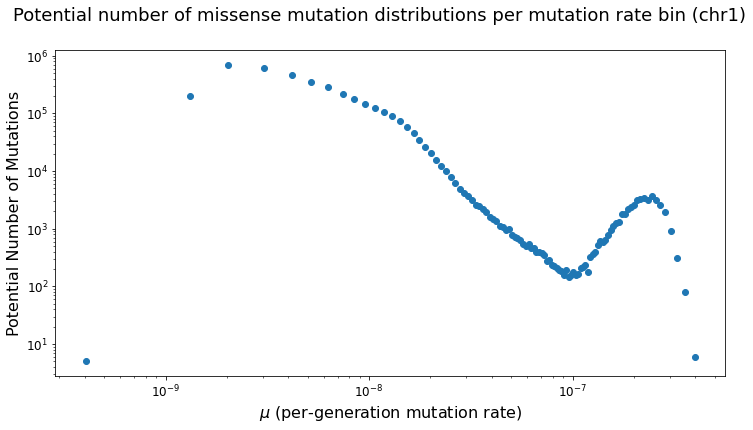

In [16]:
muBins = dfFilterQuality80.mu.unique()
muBins = np.sort(muBins)

dfMuBins = pd.DataFrame(data = muBins)
dfMuBins.columns = ['mu_bins']
print(len(dfMuBins))
print(dfMuBins.head())

freqMu = np.zeros(len(muBins))

for i in range(len(muBins)):
    dfFilterQuality80Plot = dfFilterQuality80[dfFilterQuality80['mu'] == muBins[i]]
    freqMu[i] = len(dfFilterQuality80Plot)
    
print(freqMu)

dfMuBins['freq'] = freqMu.tolist()

perGenConstant = 1.01482054e-7
dfMuBins['mu_bins'] = dfMuBins['mu_bins'] * perGenConstant

print(dfMuBins.head())

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
plt.xscale("log")
plt.yscale("log")
plt.scatter(dfMuBins['mu_bins'], dfMuBins['freq'])

fig.suptitle('Potential number of missense mutation distributions per mutation rate bin (chr1)', fontsize=18)

plt.xlabel('$\mu$ (per-generation mutation rate)',  fontsize=16)
plt.xticks(fontsize=12)

plt.ylabel('Potential Number of Mutations',  fontsize=16)
plt.yticks(fontsize=12)

In [17]:
#dfMuBins.to_csv('mis_mu_num_mutations.csv', index=False) #Uncomment this line to store df as a csv

In [18]:
dfFilterQuality80['covg_binary'] = [1 for x in range(len(dfFilterQuality80))]
dfFilterQuality80['covg_binary'] = np.where((dfFilterQuality80.over_20 <= 0.995), 0, dfFilterQuality80.covg_binary)

muBinsNew = dfFilterQuality80.mu.unique()
muBinsNew = np.sort(muBinsNew)
# fractionBinArray1 = np.zeros(len(muBins))

# for i in range(len(muBinsNew)):
#     fractionFreqGreater0 = 0
#     dfBinned = dfFilterQuality80[dfFilterQuality80['mu'] == muBinsNew[i]]
#     #print(dfBinned.head())
#     #print(dfBinned.tail())
#     dfGreaterZero = dfBinned[dfBinned['freq'] > 0]
    
#     fractionFreqGreater0 = len(dfGreaterZero) / len(dfBinned)
#     fractionBinArray1[i] = fractionFreqGreater0

# dictionary = dict(zip(muBinsNew, fractionBinArray1))

# dfFilterQuality80['prop_sites'] = dfFilterQuality80['mu'].map(dictionary)
# dfFilterQuality80['mut_type'] = ['missense' for x in range(len(dfFilterQuality80))]

print(dfFilterQuality80.head())

      chrom     pos             gene ref alt      freq  \
1493      1  925945  ENSG00000187634   T   A  0.000000   
1494      1  925945  ENSG00000187634   T   C  0.000000   
1495      1  925945  ENSG00000187634   T   G  0.000000   
1496      1  925946  ENSG00000187634   C   G  0.000012   
1497      1  925946  ENSG00000187634   C   T  0.000000   

                           PPH AA_change     mu  qual  ... rf_label  \
1493  possibly_damaging(0.883)   Ser2Thr  0.030  high  ...      NaN   
1494             benign(0.086)   Ser2Pro  0.051  high  ...      NaN   
1495   possibly_damaging(0.77)   Ser2Ala  0.020  high  ...      NaN   
1496  probably_damaging(0.987)   Ser2Cys  0.073  high  ...      NaN   
1497  probably_damaging(0.972)   Ser2Phe  0.198  high  ...      NaN   

      interp_dist  GIAB  CpG_context  logistic_freq    log_mu log_mu_squared  \
1493            1     1          0.0              0 -1.522879       2.319160   
1494            1     1          0.0              0 -1.292430   

In [19]:
propFFF = np.zeros(len(muBins))
for i in range(len(muBinsNew)):
    fractionFreqGreater0 = 0
    dfBinned0 = dfFilterQuality80[dfFilterQuality80['mu'] == muBinsNew[i]]
    dfF0 = dfBinned0[dfBinned0['GIAB'] == 0]
    dfFF0 = dfF0[dfF0['CpG_context'] == 0]
    
    #GIAB = 0, CpG = 0, Cov = 0
    dfFFF0 = dfFF0[dfFF0['covg_binary'] == 0] 
    dfGreaterZero = dfFFF0[dfFFF0['freq'] > 0]
    if (len(dfFFF0) != 0):
        fractionFreqGreater0 = len(dfGreaterZero) / len(dfFFF0)
    else:
        fractionFreqGreater0 = np.nan
    propFFF[i] = fractionFreqGreater0
    
print(propFFF)

dfMuBinsNew0 = pd.DataFrame(data = muBinsNew, columns=['mu_bins'])
dfMuBinsNew0['prop'] = propFFF.tolist() 
dfMuBinsNew0['GIAB'] = [0 for x in range(len(muBinsNew))]
dfMuBinsNew0['CpG_context'] = [0 for x in range(len(muBinsNew))]
dfMuBinsNew0['Cov'] = [0 for x in range(len(muBinsNew))]

print(dfMuBinsNew0.head())

[0.         0.01452938 0.02162204 0.03256052 0.04444031 0.05542872
 0.06575058 0.0758972  0.08656015 0.09852123 0.11019874 0.12420978
 0.13273823 0.14297909 0.15658609 0.1648734  0.17368866 0.18941846
 0.20562616 0.21795374 0.23242972 0.23966194 0.24332456 0.26483357
 0.26887661 0.29558824 0.30629853 0.30190476 0.32978723 0.33087331
 0.35382309 0.35504886 0.38230088 0.41266376 0.36138614 0.42779292
 0.41666667 0.43986254 0.42804428 0.42424242 0.47389558 0.41409692
 0.47826087 0.54189944 0.5        0.51123596 0.46357616 0.52413793
 0.50735294 0.53076923 0.51937984 0.59375    0.48101266 0.55813953
 0.65079365 0.61666667 0.46808511 0.65306122 0.71428571 0.64285714
 0.68888889 0.71428571 0.47619048 0.64285714 0.66666667 0.63636364
 0.83333333 0.84615385 1.         0.75       1.         1.
 1.         0.5               nan 1.                nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
   

In [20]:
propTFF = np.zeros(len(muBins))
for i in range(len(muBinsNew)):
    fractionFreqGreater1 = 0
    dfBinned1 = dfFilterQuality80[dfFilterQuality80['mu'] == muBinsNew[i]]
    dfT1 = dfBinned1[dfBinned1['GIAB'] == 1]
    dfTF1 = dfT1[dfT1['CpG_context'] == 0]
    
    #GIAB = 0, CpG = 0, Cov = 0
    dfTFF1 = dfTF1[dfTF1['covg_binary'] == 0] 
    dfGreaterZero1 = dfTFF1[dfTFF1['freq'] > 0]
    if (len(dfTFF1) != 0):
        fractionFreqGreater1 = len(dfGreaterZero1) / len(dfTFF1)
    else: 
        fractionFreqGreater1 = np.nan
    propTFF[i] = fractionFreqGreater1

print(propTFF)

dfMuBinsNew1 = pd.DataFrame(data = muBinsNew, columns=['mu_bins'])
dfMuBinsNew1['prop'] = propTFF.tolist() 
dfMuBinsNew1['GIAB'] = [1 for x in range(len(muBinsNew))]
dfMuBinsNew1['CpG_context'] = [0 for x in range(len(muBinsNew))]
dfMuBinsNew1['Cov'] = [0 for x in range(len(muBinsNew))]

print(dfMuBinsNew1.head())

[       nan 0.01534159 0.02495956 0.03486898 0.04764281 0.05823206
 0.06704907 0.07898327 0.08916421 0.10004738 0.11279868 0.1297829
 0.13986706 0.14488035 0.16217883 0.17283629 0.18345212 0.18710758
 0.1895355  0.21180556 0.21624007 0.25921909 0.25947522 0.26902655
 0.24193548 0.30659026 0.26013514 0.28813559 0.28248588 0.33108108
 0.30894309 0.37815126 0.39361702 0.31884058 0.43243243 0.36363636
 0.38596491 0.3902439  0.46428571 0.5        0.42424242 0.40540541
 0.5862069  0.375      0.5        0.65       0.42105263 0.52941176
 0.45       0.45       0.53333333 0.27272727 0.6        0.30769231
 0.875      0.5        0.6        0.8        0.8        0.75
 1.                nan 0.5        1.         0.5        1.
 0.33333333 1.         0.33333333        nan 1.                nan
 0.5               nan 1.         0.                nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        na

In [21]:
propFTF = np.zeros(len(muBins))
for i in range(len(muBinsNew)):
    fractionFreqGreater2 = 0
    dfBinned2 = dfFilterQuality80[dfFilterQuality80['mu'] == muBinsNew[i]]
    dfF2 = dfBinned2[dfBinned2['GIAB'] == 0]
    dfFT2 = dfF2[dfF2['CpG_context'] == 1]
    
    #GIAB = 0, CpG = 0, Cov = 0
    dfFTF2 = dfFT2[dfFT2['covg_binary'] == 0] 
    dfGreaterZero2 = dfFTF2[dfFTF2['freq'] > 0]
    if (len(dfFTF2) != 0):
        fractionFreqGreater2 = len(dfGreaterZero2) / len(dfFTF2)
    else:
        fractionFreqGreater2 = np.nan
    propFTF[i] = fractionFreqGreater2

print(propFTF)

dfMuBinsNew2 = pd.DataFrame(data = muBinsNew, columns=['mu_bins'])
dfMuBinsNew2['prop'] = propFTF.tolist() 
dfMuBinsNew2['GIAB'] = [0 for x in range(len(muBinsNew))]
dfMuBinsNew2['CpG_context'] = [1 for x in range(len(muBinsNew))]
dfMuBinsNew2['Cov'] = [0 for x in range(len(muBinsNew))]

print(dfMuBinsNew2.head())

[       nan        nan        nan        nan        nan        nan
 0.2        0.08910891 0.09343434 0.09461967 0.10644258 0.12571429
 0.15268987 0.14897579 0.17377049 0.13927577 0.18996416 0.19496855
 0.20754717 0.17977528 0.3030303  0.27027027 0.29577465 0.24590164
 0.29577465 0.27941176 0.17647059 0.34090909 0.30769231 0.2173913
 0.29230769 0.44736842 0.34782609 0.38636364 0.4        0.2
 0.47826087 0.26086957 0.46938776 0.35483871 0.42105263 0.53333333
 0.375      0.5        0.38461538 0.42857143 0.76923077 0.58333333
 0.58333333 0.66666667 0.66666667 0.64705882 0.72727273 0.66666667
 0.71428571 0.6875     0.66666667 0.46666667 0.61111111 0.5
 0.68965517 0.47619048 0.6969697  0.74193548 0.5862069  0.82142857
 0.65306122 0.66666667 0.83333333 0.65957447 0.74157303 0.77142857
 0.70634921 0.80272109 0.72282609 0.7247191  0.77435897 0.74131274
 0.76816609 0.76021798 0.77541371 0.76510067 0.77777778 0.8013245
 0.83166904 0.81292059 0.82198327 0.82248521 0.84048507 0.8537234
 0.83568548 

In [22]:
propFFT = np.zeros(len(muBins))
for i in range(len(muBinsNew)):
    fractionFreqGreater3 = 0
    dfBinned3 = dfFilterQuality80[dfFilterQuality80['mu'] == muBinsNew[i]]
    dfF3 = dfBinned3[dfBinned3['GIAB'] == 0]
    dfFF3 = dfF3[dfF3['CpG_context'] == 0]
    
    #GIAB = 0, CpG = 0, Cov = 0
    dfFFT3 = dfFF3[dfFF3['covg_binary'] == 1] 
    dfGreaterZero3 = dfFFT3[dfFFT3['freq'] > 0]
    if (len(dfFFT3) != 0):
        fractionFreqGreater3 = len(dfGreaterZero3) / len(dfFFT3)
    else:
        fractionFreqGreater3 = np.nan
    propFFT[i] = fractionFreqGreater3

print(propFFT)

dfMuBinsNew3 = pd.DataFrame(data = muBinsNew, columns=['mu_bins'])
dfMuBinsNew3['prop'] = propFFT.tolist() 
dfMuBinsNew3['GIAB'] = [0 for x in range(len(muBinsNew))]
dfMuBinsNew3['CpG_context'] = [0 for x in range(len(muBinsNew))]
dfMuBinsNew3['Cov'] = [1 for x in range(len(muBinsNew))]

print(dfMuBinsNew3.head())

[0.         0.01460637 0.02230091 0.03309044 0.04410761 0.05558932
 0.06675256 0.07678886 0.08786379 0.10220039 0.11169529 0.12472605
 0.13745964 0.14893322 0.15257796 0.17362686 0.17962343 0.19008836
 0.20303963 0.2185301  0.22205589 0.2428866  0.24777137 0.27424094
 0.25661487 0.2861461  0.31246377 0.32460733 0.35102041 0.35008818
 0.34804413 0.37090909 0.33921303 0.35312024 0.4091653  0.44685039
 0.4691358  0.46924829 0.45864662 0.47214076 0.4695122  0.48220065
 0.46822742 0.47535211 0.48971193 0.51449275 0.50420168 0.49779736
 0.5698324  0.53191489 0.48587571 0.51533742 0.50833333 0.5754717
 0.63551402 0.65517241 0.58333333 0.58461538 0.75806452 0.46938776
 0.70212766 0.575      0.62068966 0.68965517 0.66666667 0.875
 0.64285714 0.75       0.85714286 0.42857143 0.85714286 0.66666667
 0.66666667 0.6        0.66666667 1.                nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 

In [23]:
propTTF = np.zeros(len(muBins))
for i in range(len(muBinsNew)):
    fractionFreqGreater4 = 0
    dfBinned4 = dfFilterQuality80[dfFilterQuality80['mu'] == muBinsNew[i]]
    dfT4 = dfBinned4[dfBinned4['GIAB'] == 1]
    dfTT4 = dfT4[dfT4['CpG_context'] == 1]
    
    #GIAB = 0, CpG = 0, Cov = 0
    dfTTF4 = dfTT4[dfTT4['covg_binary'] == 0] 
    dfGreaterZero4 = dfTTF4[dfTTF4['freq'] > 0]
    if (len(dfTTF4) != 0):
        fractionFreqGreater4 = len(dfGreaterZero4) / len(dfTTF4)
    else:
        fractionFreqGreater4 = np.nan
    propTTF[i] = fractionFreqGreater4

print(propTTF)

dfMuBinsNew4 = pd.DataFrame(data = muBinsNew, columns=['mu_bins'])
dfMuBinsNew4['prop'] = propTTF.tolist() 
dfMuBinsNew4['GIAB'] = [1 for x in range(len(muBinsNew))]
dfMuBinsNew4['CpG_context'] = [1 for x in range(len(muBinsNew))]
dfMuBinsNew4['Cov'] = [0 for x in range(len(muBinsNew))]

print(dfMuBinsNew4.head())

[       nan        nan        nan        nan        nan        nan
 0.         0.04166667 0.06818182 0.09620991 0.12483574 0.12668161
 0.13913043 0.13363029 0.14110429 0.15315315 0.15891473 0.17010309
 0.13114754 0.265      0.23026316 0.2037037  0.20625    0.26627219
 0.22151899 0.23837209 0.2748538  0.2991453  0.23931624 0.24503311
 0.30102041 0.31515152 0.27368421 0.25       0.29126214 0.35820896
 0.375      0.25       0.31578947 0.31578947 0.41666667 0.28571429
 0.4047619  0.37037037 0.52173913 0.28571429 0.25       0.45454545
 0.375      0.47619048 0.6        0.59259259 0.61538462 0.51515152
 0.55555556 0.45       0.75       0.63636364 0.59259259 0.5
 0.53846154 0.55882353 0.69230769 0.58139535 0.59375    0.5952381
 0.78378378 0.64150943 0.69230769 0.73684211 0.66101695 0.71232877
 0.68253968 0.69230769 0.70588235 0.6875     0.65656566 0.75555556
 0.75590551 0.77844311 0.74269006 0.75722543 0.84722222 0.80084746
 0.85873606 0.85947712 0.82075472 0.83776596 0.82926829 0.86060606
 0.

In [24]:
propFTT = np.zeros(len(muBins))
for i in range(len(muBinsNew)):
    fractionFreqGreater5 = 0
    dfBinned5 = dfFilterQuality80[dfFilterQuality80['mu'] == muBinsNew[i]]
    dfF5 = dfBinned5[dfBinned5['GIAB'] == 0]
    dfFT5 = dfF5[dfF5['CpG_context'] == 1]
    
    #GIAB = 0, CpG = 0, Cov = 0
    dfFTT5 = dfFT5[dfFT5['covg_binary'] == 1] 
    dfGreaterZero5 = dfFTT5[dfFTT5['freq'] > 0]
    if (len(dfFTT5) != 0):
        fractionFreqGreater5 = len(dfGreaterZero5) / len(dfFTT5)
    else:
        fractionFreqGreater5 = np.nan
    propFTT[i] = fractionFreqGreater5

print(propFTT)

dfMuBinsNew5 = pd.DataFrame(data = muBinsNew, columns=['mu_bins'])
dfMuBinsNew5['prop'] = propFTT.tolist() 
dfMuBinsNew5['GIAB'] = [0 for x in range(len(muBinsNew))]
dfMuBinsNew5['CpG_context'] = [1 for x in range(len(muBinsNew))]
dfMuBinsNew5['Cov'] = [1 for x in range(len(muBinsNew))]

print(dfMuBinsNew5.head())

[       nan        nan        nan        nan        nan        nan
 0.         0.10344828 0.09532062 0.09549072 0.1137102  0.11574328
 0.12367865 0.13017356 0.1814346  0.15268456 0.19285714 0.1563981
 0.19767442 0.27184466 0.20481928 0.27835052 0.25675676 0.27118644
 0.27586207 0.36065574 0.25       0.39622642 0.38461538 0.43421053
 0.27160494 0.296875   0.14705882 0.26315789 0.41463415 0.40816327
 0.37931034 0.39534884 0.46376812 0.30232558 0.11111111 0.4516129
 0.42857143 0.375      0.36363636 0.25       0.75       0.54545455
 0.6        0.5        0.47058824 0.58333333 0.5        0.54545455
 0.69230769 0.57894737 0.66666667 0.5862069  0.72727273 0.75
 0.5625     0.64285714 0.68421053 0.69387755 0.71666667 0.72727273
 0.75342466 0.57692308 0.66666667 0.72857143 0.72661871 0.69461078
 0.7606383  0.75688073 0.72972973 0.75451264 0.75409836 0.71834625
 0.75826446 0.77865613 0.76847291 0.7651633  0.75858124 0.81924883
 0.80223881 0.81522669 0.80265211 0.82677665 0.83663366 0.85751128
 0.

In [25]:
propTFT = np.zeros(len(muBins))
for i in range(len(muBinsNew)):
    fractionFreqGreater6 = 0
    dfBinned6 = dfFilterQuality80[dfFilterQuality80['mu'] == muBinsNew[i]]
    dfT6 = dfBinned6[dfBinned6['GIAB'] == 1]
    dfTF6 = dfT6[dfT6['CpG_context'] == 0]
    
    #GIAB = 0, CpG = 0, Cov = 0
    dfTFT6 = dfTF6[dfTF6['covg_binary'] == 1] 
    dfGreaterZero6 = dfTFT6[dfTFT6['freq'] > 0]
    if (len(dfTFT6) != 0): 
        fractionFreqGreater6 = len(dfGreaterZero6) / len(dfTFT6)
    else: 
        fractionFreqGreater6 = np.nan
    propTFT[i] = fractionFreqGreater6

print(propTFT)

dfMuBinsNew6 = pd.DataFrame(data = muBinsNew, columns=['mu_bins'])
dfMuBinsNew6['prop'] = propTFT.tolist() 
dfMuBinsNew6['GIAB'] = [1 for x in range(len(muBinsNew))]
dfMuBinsNew6['CpG_context'] = [0 for x in range(len(muBinsNew))]
dfMuBinsNew6['Cov'] = [1 for x in range(len(muBinsNew))]

print(dfMuBinsNew6.head())

[       nan 0.01634349 0.02466083 0.03441718 0.04575715 0.05957154
 0.06862962 0.08081601 0.09532876 0.09807023 0.11898594 0.12930233
 0.13327745 0.15350032 0.16428295 0.17607973 0.20188679 0.20066061
 0.21894094 0.22766571 0.2283105  0.21632653 0.26649746 0.29568106
 0.30735931 0.26455026 0.29192547 0.36220472 0.36153846 0.37894737
 0.36       0.31578947 0.42857143 0.31372549 0.47272727 0.5
 0.47916667 0.42307692 0.3        0.38461538 0.57894737 0.47058824
 0.37037037 0.47058824 0.5        0.41176471 0.55555556 0.4
 0.53333333 0.5        0.375      0.63636364 0.66666667 0.71428571
 0.66666667 0.6        0.66666667 0.75       0.75       0.5
 0.8        0.5        0.6        0.         1.                nan
 0.6        1.         0.                nan        nan        nan
 1.         1.                nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan     

In [26]:
propTTT = np.zeros(len(muBins))
for i in range(len(muBinsNew)):
    fractionFreqGreater7 = 0
    dfBinned7 = dfFilterQuality80[dfFilterQuality80['mu'] == muBinsNew[i]]
    dfT7 = dfBinned7[dfBinned7['GIAB'] == 1]
    dfTT7 = dfT7[dfT7['CpG_context'] == 1]
    
    #GIAB = 0, CpG = 0, Cov = 0
    dfTTT7 = dfTT7[dfTT7['covg_binary'] == 1] 
    dfGreaterZero7 = dfTTT7[dfTTT7['freq'] > 0]
    if (len(dfTTT7) != 0):
        fractionFreqGreater7 = len(dfGreaterZero7) / len(dfTTT7)
    else: 
        fractionFreqGreater7 = np.nan
    propTTT[i] = fractionFreqGreater7

print(propTTT)

dfMuBinsNew7 = pd.DataFrame(data = muBinsNew, columns=['mu_bins'])
dfMuBinsNew7['prop'] = propTTT.tolist() 
dfMuBinsNew7['GIAB'] = [1 for x in range(len(muBinsNew))]
dfMuBinsNew7['CpG_context'] = [1 for x in range(len(muBinsNew))]
dfMuBinsNew7['Cov'] = [1 for x in range(len(muBinsNew))]

print(dfMuBinsNew7.head())

[       nan        nan        nan        nan        nan        nan
 0.         0.08333333 0.14084507 0.06306306 0.164      0.15
 0.17088608 0.16262976 0.13888889 0.16964286 0.16666667 0.11627907
 0.24242424 0.18181818 0.18181818 0.13953488 0.33333333 0.10714286
 0.22222222 0.27777778 0.13043478 0.31578947 0.1875     0.13793103
 0.29032258 0.225      0.17391304 0.11111111 0.21052632 0.66666667
 0.45454545 0.23529412 0.20833333 0.5        0.42857143 0.53846154
 0.4        0.42857143 0.75       1.         0.5        0.4
 0.33333333 0.5        0.5        0.375      0.         0.6
 0.6        0.33333333 0.66666667 0.75       0.5        0.5
 0.57142857 0.55555556 0.6        0.77777778 0.6        0.7
 0.375      0.66666667 0.77777778 0.76923077 0.76       0.58823529
 0.625      0.71428571 0.76315789 0.77777778 0.68571429 0.78431373
 0.74545455 0.63513514 0.76388889 0.80597015 0.82692308 0.82905983
 0.80833333 0.816      0.86227545 0.83606557 0.81382979 0.86175115
 0.87562189 0.90041494 0.9146

In [27]:
dfMuBinsNewAll = pd.concat([dfMuBinsNew0, dfMuBinsNew1, dfMuBinsNew2, dfMuBinsNew3, dfMuBinsNew4, dfMuBinsNew5, dfMuBinsNew6, dfMuBinsNew7])
print(len(dfMuBinsNewAll))
print(dfMuBinsNewAll.head())
dfMuBinsNewAllDrop = dfMuBinsNewAll.dropna(axis='rows')
print(len(dfMuBinsNewAllDrop))
print(dfMuBinsNewAllDrop.head())

792
   mu_bins      prop  GIAB  CpG_context  Cov
0    0.004  0.000000     0            0    0
1    0.013  0.014529     0            0    0
2    0.020  0.021622     0            0    0
3    0.030  0.032561     0            0    0
4    0.041  0.044440     0            0    0
661
   mu_bins      prop  GIAB  CpG_context  Cov
0    0.004  0.000000     0            0    0
1    0.013  0.014529     0            0    0
2    0.020  0.021622     0            0    0
3    0.030  0.032561     0            0    0
4    0.041  0.044440     0            0    0


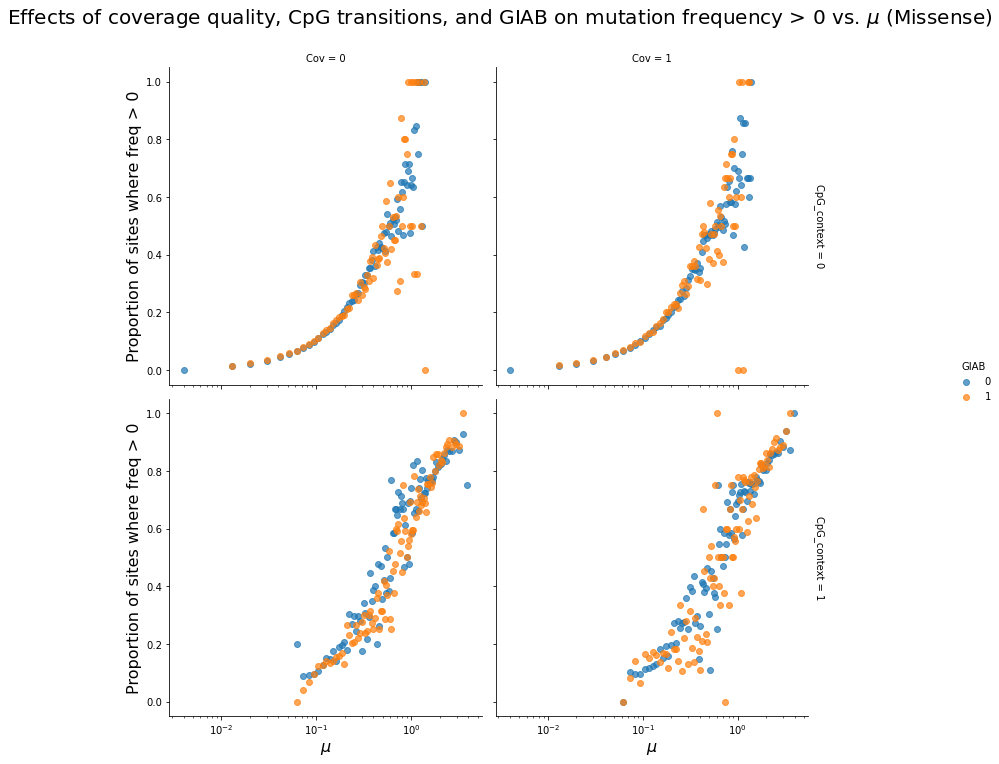

In [31]:
g = sns.FacetGrid(dfMuBinsNewAllDrop, row = "CpG_context", col="Cov", hue = "GIAB", height=5, margin_titles=True)
g.set(xscale="log")
g.map(plt.scatter, "mu_bins", "prop", alpha=.7)
#plt.xlabel('', fontsize=16)
#plt.ylabel('', fontsize=16)
g.axes[1,0].set_xlabel('$\mu$', fontsize = 16)
g.axes[1,1].set_xlabel('$\mu$', fontsize = 16)
g.axes[0,0].set_ylabel('Proportion of sites where freq > 0', fontsize = 16)
g.axes[1,0].set_ylabel('Proportion of sites where freq > 0', fontsize = 16)
g.fig.suptitle('Effects of coverage quality, CpG transitions, and GIAB on mutation frequency > 0 vs. $\mu$ (Missense)', y=1.05, fontsize=20)
g.add_legend()

In [ ]:
#dfFilterQuality80.to_csv('mis_effects_plot.csv', index=False) #Uncomment this line to store df as a csv